# VQD Comparisons

This notebook is a **pure package client** for comparing **VQD performance** across:

1) **Optimizers** (fixed ansatz, with optimizer-specific step sizes)
2) **Ansatzes** (fixed optimizer)

It calls `vqe.vqd.run_vqd(...)` only and prints compact comparison tables.

In [ ]:
from __future__ import annotations

import math
from typing import Any, Dict, List
import pennylane as qml
import numpy as np

from vqe.vqd import run_vqd
from vqe.hamiltonian import build_hamiltonian

## Experiment configuration

Adjust these parameters as needed.

In [ ]:
# -----------------------------
# Problem / run configuration
# -----------------------------
molecule = "H2"
num_states = 2
seed = 0
noisy = False
depolarizing_prob = 0.0
amplitude_damping_prob = 0.0

# VQD penalty schedule (recommended defaults)
beta = 10.0
beta_start = 0.0
beta_ramp = "cosine"
beta_hold_fraction = 0.1

# Optimization budget
steps = 250

# -----------------------------
# Optimizer sweep configuration
# -----------------------------
optimizers = ["Adam", "GradientDescent", "Momentum", "Nesterov", "RMSProp", "Adagrad"]
stepsize_map = {
    "Adam": 0.2,
    "GradientDescent": 0.05,
    "Momentum": 0.1,
    "Nesterov": 0.1,
    "RMSProp": 0.1,
    "Adagrad": 0.2,
}

# Fixed ansatz for optimizer comparisons
fixed_ansatz_for_optimizer_sweep = "UCCSD"

# -----------------------------
# Ansatz sweep configuration
# -----------------------------
ansatzes = [
    "UCC-S",
    "UCC-D",
    "UCCSD",
    "Minimal",
    "RY-CZ",
    "TwoQubit-RY-CNOT",
    "StronglyEntanglingLayers",
]

# Fixed optimizer for ansatz comparisons
fixed_optimizer_for_ansatz_sweep = "Adam"
fixed_stepsize_for_ansatz_sweep = stepsize_map[fixed_optimizer_for_ansatz_sweep]

## Utility: exact spectrum (benchmark)

This prints the lowest eigenvalues of the Hamiltonian built by your package.

In [ ]:
H, n_wires, symbols, coordinates, basis = build_hamiltonian(molecule)
evals = np.sort(np.linalg.eigvalsh(np.array(qml.matrix(H))))

print(f"Molecule: {molecule}")
print(f"Qubits:   {n_wires}")
print(f"Basis:    {basis}")
print("Exact lowest 10 eigenvalues (Ha):")
for i, e in enumerate(evals[:10]):
    print(f"#{i:>2}: {float(e): .10f}")

## Utility: run VQD once and summarize results

In [ ]:
def _run_vqd_once(
    *,
    ansatz_name: str,
    optimizer_name: str,
    stepsize: float,
) -> Dict[str, Any]:
    """
    Run VQD once (single seed) and return summary:
      - final energies for each state
      - full result dict
    """
    result = run_vqd(
        molecule=molecule,
        num_states=num_states,
        beta=beta,
        beta_start=beta_start,
        beta_ramp=beta_ramp,
        beta_hold_fraction=beta_hold_fraction,
        ansatz_name=ansatz_name,
        optimizer_name=optimizer_name,
        steps=steps,
        stepsize=stepsize,
        seed=seed,
        noisy=noisy,
        depolarizing_prob=depolarizing_prob,
        amplitude_damping_prob=amplitude_damping_prob,
        plot=False,
        force=False,
    )

    energies_per_state = result["energies_per_state"]
    finals = [float(traj[-1]) for traj in energies_per_state]

    return {
        "ansatz": ansatz_name,
        "optimizer": optimizer_name,
        "stepsize": float(stepsize),
        "E0_final": finals[0],
        "E1_final": finals[1] if len(finals) > 1 else math.nan,
        "result": result,
    }


def _print_table(rows: List[Dict[str, Any]], *, title: str) -> None:
    """
    Simple aligned-print table (no extra dependencies).
    """
    if not rows:
        print(f"\n{title}\n(no rows)\n")
        return

    cols = ["ansatz", "optimizer", "stepsize", "E0_final", "E1_final"]
    headers = {
        "ansatz": "Ansatz",
        "optimizer": "Optimizer",
        "stepsize": "Stepsize",
        "E0_final": "E0 (final, Ha)",
        "E1_final": "E1 (final, Ha)",
    }

    # compute widths
    def fmt(col: str, val: Any) -> str:
        if col in {"E0_final", "E1_final"}:
            return f"{val: .10f}"
        if col == "stepsize":
            return f"{val:g}"
        return str(val)

    widths = {c: len(headers[c]) for c in cols}
    for r in rows:
        for c in cols:
            widths[c] = max(widths[c], len(fmt(c, r[c])))

    # print
    print("\n" + title)
    line = "  ".join(headers[c].ljust(widths[c]) for c in cols)
    print(line)
    print("-" * len(line))
    for r in rows:
        print("  ".join(fmt(c, r[c]).ljust(widths[c]) for c in cols))

## 1) Optimizer comparison (fixed ansatz)

In [ ]:
optimizer_rows: List[Dict[str, Any]] = []

for opt in optimizers:
    ss = stepsize_map[opt]
    print(f"Running VQD: ansatz={fixed_ansatz_for_optimizer_sweep}, optimizer={opt}, stepsize={ss} ...")
    row = _run_vqd_once(
        ansatz_name=fixed_ansatz_for_optimizer_sweep,
        optimizer_name=opt,
        stepsize=ss,
    )
    optimizer_rows.append(row)

# Sort by excited-state energy (lower is better, but note degeneracy/subspace effects)
optimizer_rows_sorted = sorted(optimizer_rows, key=lambda r: r["E1_final"])

_print_table(
    optimizer_rows_sorted,
    title=f"VQD Optimizer Comparison (fixed ansatz = {fixed_ansatz_for_optimizer_sweep})",
)

## 2) Ansatz comparison (fixed optimizer)

In [ ]:
ansatz_rows: List[Dict[str, Any]] = []

for ans in ansatzes:
    print(f"Running VQD: ansatz={ans}, optimizer={fixed_optimizer_for_ansatz_sweep}, stepsize={fixed_stepsize_for_ansatz_sweep} ...")
    row = _run_vqd_once(
        ansatz_name=ans,
        optimizer_name=fixed_optimizer_for_ansatz_sweep,
        stepsize=fixed_stepsize_for_ansatz_sweep,
    )
    ansatz_rows.append(row)

# Sort by excited-state energy (lower is better, but interpret with exact spectrum in mind)
ansatz_rows_sorted = sorted(ansatz_rows, key=lambda r: r["E1_final"])

_print_table(
    ansatz_rows_sorted,
    title=f"VQD Ansatz Comparison (fixed optimizer = {fixed_optimizer_for_ansatz_sweep}, stepsize = {fixed_stepsize_for_ansatz_sweep})",
)

## 3) Full grid: all optimizer × ansatz combinations

Runs VQD for every (ansatz, optimizer) pair using:
  - stepsize = stepsize_map[optimizer]

and prints a table sorted by E1_final (then E0_final).

In [ ]:
grid_rows: List[Dict[str, Any]] = []

for ans in ansatzes:
    for opt in optimizers:
        ss = stepsize_map[opt]
        print(f"Running VQD: ansatz={ans}, optimizer={opt}, stepsize={ss} ...")
        row = _run_vqd_once(
            ansatz_name=ans,
            optimizer_name=opt,
            stepsize=ss,
        )
        grid_rows.append(row)

grid_rows_sorted = sorted(grid_rows, key=lambda r: (r["E1_final"], r["E0_final"]))

_print_table(
    grid_rows_sorted,
    title="VQD Full Grid (all ansatz × optimizer combos)",
)

## 4) Choose the "best" configuration (by energy error vs exact spectrum)

We define:
  - ΔE0 = |E0_final - E0_exact|
  - ΔE1 = min_j |E1_final - E_exact[j]|
  
(excluding j=0 by default)

Score (default):
  score = ΔE0 + ΔE1

Notes:
  - For molecules with degeneracies, ΔE1-to-nearest is the most robust default.
  - If you want to force the *first excited* eigenvalue specifically, change the target.


In [ ]:
# def _nearest_excited_error(E1: float, exact_evals: np.ndarray, *, exclude_ground: bool = True) -> float:
#     vals = exact_evals[1:] if exclude_ground and len(exact_evals) > 1 else exact_evals
#     return float(np.min(np.abs(vals - E1)))


# def _score_row(row: Dict[str, Any], exact_evals: np.ndarray) -> Dict[str, Any]:
#     E0_exact = float(exact_evals[0])
#     dE0 = abs(float(row["E0_final"]) - E0_exact)
#     dE1 = _nearest_excited_error(float(row["E1_final"]), exact_evals, exclude_ground=True)
#     score = dE0 + dE1
#     out = dict(row)
#     out["dE0"] = dE0
#     out["dE1"] = dE1
#     out["score"] = score
#     return out


excited_target_mode = "first"   # "first" or "low_k"
excited_target_k = 6            # used only when mode="low_k"

def _excited_error(E1: float, exact_evals: np.ndarray) -> float:
    if excited_target_mode == "first":
        return float(abs(E1 - float(exact_evals[1])))
    if excited_target_mode == "low_k":
        tgt = exact_evals[1 : 1 + int(excited_target_k)]
        return float(np.min(np.abs(tgt - E1)))
    raise ValueError("excited_target_mode must be 'first' or 'low_k'.")

def _score_row(row: Dict[str, Any], exact_evals: np.ndarray) -> Dict[str, Any]:
    E0_exact = float(exact_evals[0])
    dE0 = abs(float(row["E0_final"]) - E0_exact)
    dE1 = _excited_error(float(row["E1_final"]), exact_evals)
    score = dE0 + dE1
    out = dict(row)
    out["dE0"] = dE0
    out["dE1"] = dE1
    out["score"] = score
    return out


scored = [_score_row(r, evals) for r in grid_rows]

# Sort by total score, then by dE1, then by dE0 (tie-breaks)
scored_sorted = sorted(scored, key=lambda r: (r["score"], r["dE1"], r["dE0"]))

best = scored_sorted[0]

print("\nBest configuration (by score = |ΔE0| + min|ΔE1|):")
print(f"  Ansatz:    {best['ansatz']}")
print(f"  Optimizer: {best['optimizer']}")
print(f"  Stepsize:  {best['stepsize']}")
print(f"  E0_final:  {best['E0_final']:.10f}   (ΔE0={best['dE0']:.3e} Ha)")
print(f"  E1_final:  {best['E1_final']:.10f}   (ΔE1={best['dE1']:.3e} Ha)")
print(f"  Score:     {best['score']:.3e}")

# Also show the top 10 configs
top_k = 10
print(f"\nTop {top_k} configurations:")
for i, r in enumerate(scored_sorted[:top_k]):
    print(
        f"{i+1:>2}. ansatz={r['ansatz']:<22} optimizer={r['optimizer']:<14} "
        f"stepsize={r['stepsize']:<5g}  "
        f"E0={r['E0_final']:.10f} (ΔE0={r['dE0']:.2e})  "
        f"E1={r['E1_final']:.10f} (ΔE1={r['dE1']:.2e})  "
        f"score={r['score']:.2e}"
    )

## 5) Validate top configurations across multiple seeds (mean ± std)

This block:
1) Takes the top-K configurations from the full grid (by score from section 4)
2) Re-runs each configuration across a small set of seeds
3) Reports mean ± std for:
   - E0_final, E1_final
   - ΔE0 vs exact ground
   - ΔE1 vs nearest exact excited eigenvalue (excluding ground)

Notes:
- This is still a "pure client": it calls `run_vqd(...)` only.
- Runtime scales as: top_k * n_seeds * steps * num_states.

In [ ]:
# Configure validation sweep
seeds = [0, 1, 2]
top_k_validate = 5  # validate top-K from the scored grid

# Choose the top K from the previously computed `scored_sorted`
top_configs = scored_sorted[:top_k_validate]

E0_exact = float(evals[0])

def _summarize_list(xs: List[float]) -> tuple[float, float]:
    arr = np.array(xs, dtype=float)
    return float(arr.mean()), float(arr.std(ddof=1)) if len(arr) > 1 else (float(arr.mean()), 0.0)

validation_rows: List[Dict[str, Any]] = []

for cfg_i, cfg_row in enumerate(top_configs, start=1):
    ans = cfg_row["ansatz"]
    opt = cfg_row["optimizer"]
    ss = float(cfg_row["stepsize"])

    E0s: List[float] = []
    E1s: List[float] = []
    dE0s: List[float] = []
    dE1s: List[float] = []

    print(f"\nValidating {cfg_i}/{len(top_configs)}: ansatz={ans}, optimizer={opt}, stepsize={ss} over seeds={seeds}")

    for s in seeds:
        # override the notebook-level seed for this run
        seed_saved = seed
        seed = int(s)
        out = _run_vqd_once(ansatz_name=ans, optimizer_name=opt, stepsize=ss)
        seed = seed_saved  # restore

        E0 = float(out["E0_final"])
        E1 = float(out["E1_final"])
        E0s.append(E0)
        E1s.append(E1)
        dE0s.append(abs(E0 - E0_exact))
        # dE1s.append(_nearest_excited_error(E1, evals, exclude_ground=True))
        dE1s.append(_excited_error(E1, evals))

    E0_mean, E0_std = _summarize_list(E0s)
    E1_mean, E1_std = _summarize_list(E1s)
    dE0_mean, dE0_std = _summarize_list(dE0s)
    dE1_mean, dE1_std = _summarize_list(dE1s)

    validation_rows.append(
        {
            "ansatz": ans,
            "optimizer": opt,
            "stepsize": ss,
            "E0_mean": E0_mean,
            "E0_std": E0_std,
            "E1_mean": E1_mean,
            "E1_std": E1_std,
            "dE0_mean": dE0_mean,
            "dE0_std": dE0_std,
            "dE1_mean": dE1_mean,
            "dE1_std": dE1_std,
            "score_mean": dE0_mean + dE1_mean,
        }
    )

# Sort by mean score, then stability (std)
validation_rows_sorted = sorted(
    validation_rows,
    key=lambda r: (r["score_mean"], r["dE1_std"], r["dE0_std"]),
)

# Pretty print a compact summary (no external deps)
print("\nMulti-seed validation summary (sorted by mean score):")
hdr = (
    f"{'Ansatz':<22}  {'Optimizer':<14}  {'SS':<5}  "
    f"{'E0 mean±std':<26}  {'E1 mean±std':<26}  "
    f"{'ΔE0 mean±std':<26}  {'ΔE1 mean±std':<26}  {'score_mean':<10}"
)
print(hdr)
print("-" * len(hdr))

for r in validation_rows_sorted:
    print(
        f"{r['ansatz']:<22}  {r['optimizer']:<14}  {r['stepsize']:<5g}  "
        f"{r['E0_mean']:+.10f}±{r['E0_std']:.2e}  "
        f"{r['E1_mean']:+.10f}±{r['E1_std']:.2e}  "
        f"{r['dE0_mean']:.2e}±{r['dE0_std']:.2e}  "
        f"{r['dE1_mean']:.2e}±{r['dE1_std']:.2e}  "
        f"{r['score_mean']:.2e}"
    )

best_mean = validation_rows_sorted[0]
print("\nBest configuration by mean score across seeds:")
print(f"  Ansatz:    {best_mean['ansatz']}")
print(f"  Optimizer: {best_mean['optimizer']}")
print(f"  Stepsize:  {best_mean['stepsize']}")
print(f"  E0:        {best_mean['E0_mean']:+.10f} ± {best_mean['E0_std']:.2e}")
print(f"  E1:        {best_mean['E1_mean']:+.10f} ± {best_mean['E1_std']:.2e}")
print(f"  ΔE0:       {best_mean['dE0_mean']:.2e} ± {best_mean['dE0_std']:.2e}")
print(f"  ΔE1:       {best_mean['dE1_mean']:.2e} ± {best_mean['dE1_std']:.2e}")
print(f"  score:     {best_mean['score_mean']:.2e}")


/tmp/ipykernel_36516/129626122.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  Hmat = np.array(qml.matrix(H), dtype=float)


Molecule: H2
Qubits:   4
Basis:    STO-3G

Lowest 10 exact eigenvalues (Ha):
 0: -1.1372701749
 1: -0.5387095807
 2: -0.5387095807
 3: -0.5324790143
 4: -0.5324790143
 5: -0.5324790143
 6: -0.4469857253
 7: -0.4469857253
 8: -0.1699013991
 9:  0.2378052722
📂 Using cached VQD result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__VQD(StronglyEntanglingLayers)_4states__Adam__VQD__noiseless__s0__08400c29e096.json

Noiseless VQD
State 0: E_final = -1.1372701749 Ha   |ΔE_i| vs exact[0] = 2.995e-12 Ha
State 1: E_final = -0.5324790143 Ha   |ΔE_i| vs exact[1] = 6.231e-03 Ha
State 2: E_final = -0.5324802445 Ha   |ΔE_i| vs exact[2] = 6.229e-03 Ha
State 3: E_final = -0.5387095305 Ha   |ΔE_i| vs exact[3] = 6.231e-03 Ha
📂 Using cached VQD result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__VQD(StronglyEntanglingLayers)_4states__Adam__VQD__noisy__s0__dc6de38a5282.json

Noisy VQD (built-in noise): dep=0.05, amp=0.05
State 0: E_final = -0.9915488650 Ha   |ΔE_i| vs exact[0]

/usr/local/python/3.12.1/lib/python3.12/site-packages/pennylane/numpy/tensor.py:152: ComplexWarning: Casting complex values to real discards the imaginary part
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


💾 Saved VQD run to /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__VQD(StronglyEntanglingLayers)_4states__Adam__VQD__noisy__s0__99b50c60b4ad.json


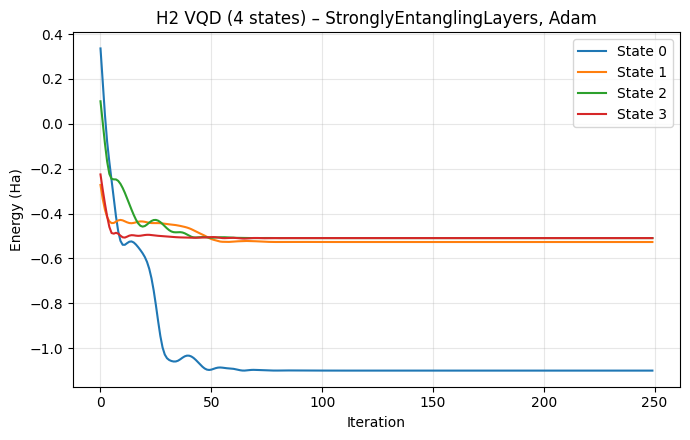

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/vqd_conv_StronglyEntanglingLayers_Adam_s0.png

Noisy VQD (custom noise_model=custom_depolarizing_p0.02)
State 0: E_final = -1.1006463554 Ha   |ΔE_i| vs exact[0] = 3.662e-02 Ha
State 1: E_final = -0.5271289926 Ha   |ΔE_i| vs exact[1] = 1.158e-02 Ha
State 2: E_final = -0.5096612275 Ha   |ΔE_i| vs exact[2] = 2.905e-02 Ha
State 3: E_final = -0.5096616245 Ha   |ΔE_i| vs exact[3] = 2.282e-02 Ha


In [1]:
# %% [markdown]
# # VQD k-state Smoke Test (Noiseless + Noisy + Custom Noise Model)
#
# Pure package client notebook.
#
# This notebook validates that:
# - VQD runs for k states (num_states=k)
# - Works noiselessly
# - Works under noise:
#   (a) depolarizing/amplitude probabilities
#   (b) arbitrary noise_model(wires) callable
#
# It prints:
# - Lowest k exact eigenvalues of H
# - VQD final energies for states 0..k-1
# - |ΔE_i| versus exact eigenvalue i (index-matched)

# %%
from __future__ import annotations

from typing import Callable, List

import numpy as np
import pennylane as qml

from vqe.hamiltonian import build_hamiltonian
from vqe.vqd import run_vqd

# %% [markdown]
# ## Configuration

# %%
molecule = "H2"

# k-state target
num_states = 4  # try 2, 3, 4 ...

# Ansatz/optimizer
ansatz_name = "StronglyEntanglingLayers"
optimizer_name = "Adam"
steps = 250
stepsize = 0.2
seed = 0

# VQD deflation schedule
beta = 10.0
beta_start = 0.0
beta_ramp = "cosine"
beta_hold_fraction = 0.1

# Noise knobs (leave at 0 for noiseless section)
depolarizing_prob = 0.0
amplitude_damping_prob = 0.0

# %% [markdown]
# ## Build Hamiltonian + exact spectrum benchmark

# %%
H, n_wires, symbols, coordinates, basis = build_hamiltonian(molecule)
Hmat = np.array(qml.matrix(H), dtype=float)
evals = np.sort(np.linalg.eigvalsh(Hmat))

print(f"Molecule: {molecule}")
print(f"Qubits:   {n_wires}")
print(f"Basis:    {basis}")
print("")
print(f"Lowest {max(10, num_states)} exact eigenvalues (Ha):")
for i, e in enumerate(evals[: max(10, num_states)]):
    print(f"{i:>2}: {float(e): .10f}")

# %% [markdown]
# ## Utility helpers

# %%
def _summarize_vqd(result: dict, exact_evals: np.ndarray, *, label: str) -> None:
    energies = result["energies_per_state"]
    finals = [float(traj[-1]) for traj in energies]

    print("\n" + "=" * 80)
    print(label)
    print("=" * 80)

    for i, Ei in enumerate(finals):
        target = float(exact_evals[i]) if i < len(exact_evals) else float("nan")
        err = abs(Ei - target) if np.isfinite(target) else float("nan")
        print(f"State {i}: E_final = {Ei:+.10f} Ha   |ΔE_i| vs exact[{i}] = {err:.3e} Ha")


def _make_custom_noise_model(*, p: float) -> Callable[[List[int]], None]:
    """
    Example arbitrary noise model (callable):
      - Applies a DepolarizingChannel(p) to each wire.
    """
    p = float(p)

    def noise_model(wires: List[int]) -> None:
        for w in wires:
            if p > 0:
                qml.DepolarizingChannel(p, wires=w)

    # Give it a stable name to help caching
    noise_model.__name__ = f"custom_depolarizing_p{p:g}"
    return noise_model


# %% [markdown]
# ## 1) Noiseless k-state VQD

# %%
res_noiseless = run_vqd(
    molecule=molecule,
    num_states=num_states,
    beta=beta,
    beta_start=beta_start,
    beta_ramp=beta_ramp,
    beta_hold_fraction=beta_hold_fraction,
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    noisy=False,
    depolarizing_prob=0.0,
    amplitude_damping_prob=0.0,
    noise_model=None,
    plot=True,
    force=False,
)

_summarize_vqd(res_noiseless, evals, label="Noiseless VQD")

# %% [markdown]
# ## 2) Noisy VQD using built-in depolarizing/amplitude probs
#
# Set one or both probabilities > 0.

# %%
depolarizing_prob = 0.05
amplitude_damping_prob = 0.05

res_builtin_noise = run_vqd(
    molecule=molecule,
    num_states=num_states,
    beta=beta,
    beta_start=beta_start,
    beta_ramp=beta_ramp,
    beta_hold_fraction=beta_hold_fraction,
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    noisy=True,
    depolarizing_prob=depolarizing_prob,
    amplitude_damping_prob=amplitude_damping_prob,
    noise_model=None,
    plot=True,
    force=False,
)

_summarize_vqd(
    res_builtin_noise,
    evals,
    label=f"Noisy VQD (built-in noise): dep={depolarizing_prob}, amp={amplitude_damping_prob}",
)

# %% [markdown]
# ## 3) Noisy VQD using a custom `noise_model(wires)` callable
#
# This validates the "any noise type" pathway.

# %%
custom_noise = _make_custom_noise_model(p=0.02)

res_custom_noise = run_vqd(
    molecule=molecule,
    num_states=num_states,
    beta=beta,
    beta_start=beta_start,
    beta_ramp=beta_ramp,
    beta_hold_fraction=beta_hold_fraction,
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    noisy=True,
    depolarizing_prob=0.0,
    amplitude_damping_prob=0.0,
    noise_model=custom_noise,
    plot=True,
    force=False,
)

_summarize_vqd(res_custom_noise, evals, label=f"Noisy VQD (custom noise_model={custom_noise.__name__})")
